In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from scipy.interpolate import interp1d
import pickle

import importlib.util
import sys

from cassL import camb_interface as ci
from cassL import user_interface as ui
from cassL import generate_emu_data as ged

In [2]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "andreap", "andreap.py")
andreap = importlib.util.module_from_spec(spec)
sys.modules["andreap"] = andreap
spec.loader.exec_module(andreap)

In [3]:
# Get the latin hypercubes so that we know which values to use for our test
# cosmological configurations.

# Eventually this kind of code should go in a user_interface.py function,
# which will automatically take the requested set and the emulator version and
# correctly translate that into a set of loaded files. That requires, of course,
# that we stick more rigorously to a file naming scheme.

data_set = "test"

fname_ending = "pred_r1" if data_set == "train" else "test"

hc = np.load("G_versions/hc_G6_" + fname_ending + ".npy",
    allow_pickle=True)
samples = np.load("G_versions/samples_G6_" + fname_ending + ".npy",
    allow_pickle=True)
rescale_params = np.load("G_versions/rescalers_G6_" + fname_ending + ".npy",
    allow_pickle=True)
    
standard_k = np.load("standard_k.npy", allow_pickle=True)

In [4]:
# Load the emulator so that we can compare our results with, say, Andrea's

m = pickle.load(open("G_versions/analyses/massive_emulator_G6_r1.nucomet", "rb"))

def inverse_transform(raw_prediction):
    return np.exp(raw_prediction * m.stdev + m.mu)

def nest(array):
    return np.array([np.array(array)])

In [5]:
percent_errors = []

In [6]:
# Select an individual cosmology to interrogate
for test_index in range(len(samples)):
    if test_index % 50 == 0:
        print()
    print(test_index, end="")
    test_cosmology = hc[test_index]
    test_pspec = samples[test_index]
    
    # Break the configuration into explicit labels
    ombh2 = test_cosmology[0]
    omch2 = test_cosmology[1]
    ns = test_cosmology[2]
    sigma12 = test_cosmology[3]
    As = test_cosmology[4]
    omnuh2 = test_cosmology[5]
    best_h = rescale_params[test_index][0]
    best_z = rescale_params[test_index][1]
    
    andrea_Pk = andreap.get_PK(ombh2, omch2, ns, omnuh2, best_h * 100, As)
    andrea_spectrum = andrea_Pk['mnu'].P(best_z, standard_k)
    
    percent_errors.append(ui.percent_error(andrea_spectrum, test_pspec))


012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849
5051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899
100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149
150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199
200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249
250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299
300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349
3503513523533543553563573583593603613623633643653663

Text(0.5, 1.0, "Andrea's power spectrum vs. Lukas' emu test spectrum")

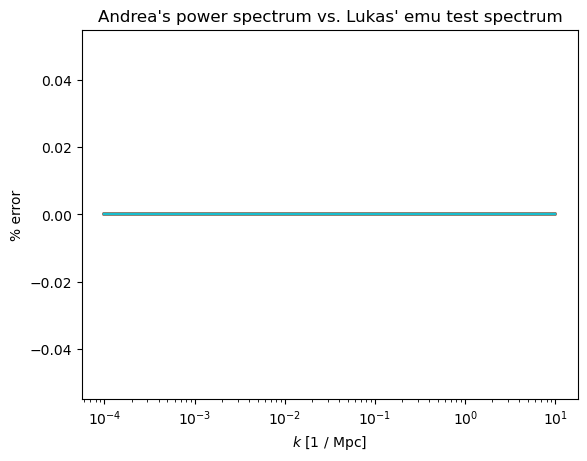

In [7]:
# Percent error comparison
for test_index in range(50):
    plt.plot(standard_k, percent_errors[test_index])

plt.xscale('log')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('% error')
plt.title("Andrea's power spectrum vs. Lukas' emu " + data_set + " spectrum")
#plt.savefig("../../plots/emulator/debugging/Andrea_old_discrepancy.png")